In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyArrowPatch

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# set fonts configuration - Arial
matplotlib.rcParams['font.family'] = "Open Sans"
matplotlib.rcParams['font.sans-serif'] = "Arial"

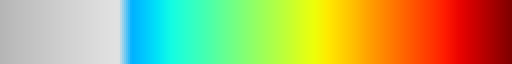

In [4]:
colors1 = plt.cm.Greys_r(np.linspace(0.6, 0.8, 10))
colors2 = plt.cm.jet(np.linspace(0.3, 1, 30))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mixedmap = LinearSegmentedColormap.from_list('my_colormap', colors)
mixedmap

In [5]:
def calc_cwv(data):
    """
    calculate CWV based on SP and q 
    cwv = q.integrate(level=(SP,0))
    """
    
    cwv = np.zeros((len(data.mcs_phase),len(data.x), len(data.y))) # (phase, x, y)
    
    for p,phase in enumerate(data.mcs_phase.values):
        for i,x in enumerate(data.x):
            for j,y in enumerate(data.y):
                q = data.sel(mcs_phase=phase, x=x, y=y).q # 27 levels
                sp = data.sel(mcs_phase=phase, x=x, y=y).SP/100 # surface pressure hPa
                cwv[p,i,j] = 100/9.8*q.sel(level=slice(100,sp)).integrate('level')
    
    # save into xarray dataset
    cwv_xr = xr.Dataset(data_vars = dict(cwv = (['mcs_phase','x','y'], cwv)),
                        coords= dict(mcs_phase = (['mcs_phase'], data.mcs_phase.values),
                                     x = (['x'], data.x.values),
                                     y = (['y'], data.y.values))
                       )
    
    return cwv_xr.cwv

In [6]:
%%time
year_list = np.arange(2001,2005,1)

bins_Tb = np.arange(180,241,1)
bins_cwv = np.arange(20,60,1)

num_oce = 0
num_lnd = 0
for n, year in enumerate(year_list):
    print('processing year: {}'.format(year))
    dir_mcs_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/')
    data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))
    
    # land sea flag
    idt_mcs_init = data_track.idt_mcs_init
    landsea_flag = data_track.isel(times=idt_mcs_init).landsea_flag
    idx_ocean = np.where(landsea_flag == 0)[0]
    idx_land = np.where(landsea_flag == 1)[0]

    tracks_sel_oce = data_track.isel(tracks=idx_ocean).tracks
    tracks_sel_lnd = data_track.isel(tracks=idx_land).tracks
    
    dir_env = Path('/scratch/wmtsai/temp_mcs/mcs_stats/envs_track/{}/tropics_extend/'.format(year))
    
    for track in tracks_sel_oce.values:
        data = xr.open_dataset(dir_env / 'mcs_era5_3D_envs_{}.{}.LD.nc'.format(year, str(track).zfill(5)))
        data = data.sel(mcs_phase='Init')
        tb = data.tb
        #cwv = calc_cwv(data)
        cwv = 100/9.8*data.q.sel(level=slice(100,900)).integrate('level')
        tb_mcs = tb.where(data.cloudtracknumber_nomergesplit > 0) # only MCS grids
        cwv_mcs = cwv.where(data.cloudtracknumber_nomergesplit > 0) # only MCS grids
        (samples, bins_out) = np.histogram(tb_mcs, bins=bins_Tb)
        (samples_cwv, bins_out) = np.histogram(cwv_mcs, bins=bins_cwv)
        
        if num_oce == 0:
            samples_Tb_oce = samples
            samples_cwv_oce = samples_cwv
            num_oce += 1
        else:
            samples_Tb_oce += samples
            samples_cwv_oce += samples_cwv
            num_oce += 1
            
    for track in tracks_sel_lnd.values:
        data = xr.open_dataset(dir_env / 'mcs_era5_3D_envs_{}.{}.LD.nc'.format(year, str(track).zfill(5)))
        data = data.sel(mcs_phase='Init')
        tb = data.tb
        #cwv = calc_cwv(data)
        cwv = 100/9.8*data.q.sel(level=slice(100,900)).integrate('level')
        tb_mcs = tb.where(data.cloudtracknumber_nomergesplit > 0) # only MCS grids
        cwv_mcs = cwv.where(data.cloudtracknumber_nomergesplit > 0) # only MCS grids
        (samples, bins_out) = np.histogram(tb_mcs, bins=bins_Tb)
        (samples_cwv, bins_out) = np.histogram(cwv_mcs, bins=bins_cwv)
        
        if num_lnd == 0:
            samples_Tb_lnd = samples
            samples_cwv_lnd = samples_cwv
            num_lnd += 1
        else:
            samples_Tb_lnd += samples
            samples_cwv_lnd += samples_cwv
            num_lnd += 1

processing year: 2001
processing year: 2002
processing year: 2003
processing year: 2004
CPU times: user 9min 34s, sys: 2min 46s, total: 12min 20s
Wall time: 12min 25s


In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,3))

ax1.plot(bins_Tb[:-1], samples_Tb_oce/samples_Tb_oce.sum(), '-b', label='MCS, Ocean')
ax1.plot(bins_Tb[:-1], samples_Tb_lnd/samples_Tb_lnd.sum(), '-g', label='MCS, land')
ax1.set_xlim([240,180])
ax1.legend(fontsize=8)
ax1.grid(lw=0.5, ls=':')
ax1.set_ylabel('Probability', fontsize=10)
ax1.set_xlabel('Brightness temperature, Tb (K)', fontsize=10)
ax1.tick_params(labelsize=9)

ax2.plot(bins_cwv[:-1], samples_cwv_oce/samples_cwv_oce.sum(), '-b', label='MCS, Ocean')
ax2.plot(bins_cwv[:-1], samples_cwv_lnd/samples_cwv_lnd.sum(), '-g', label='MCS, land')
ax2.set_xlim([30,70])
ax2.legend(fontsize=8)
ax2.grid(lw=0.5, ls=':')
ax2.set_ylabel('Probability', fontsize=10)
ax2.set_xlabel('Column water vapor,(900-100hPa) (mm)', fontsize=10)
ax2.tick_params(labelsize=9)